<a href="https://colab.research.google.com/github/linjunzh/reinforcement_learning/blob/master/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gym

from keras.models import Model
from keras.layers import Dense, Activation, Input
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import keras.backend as K

import tensorflow as tf

In [ ]:
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [ ]:
class PolicyGradient:
  def __init__(self, nb_states, nb_actions, layer1_size=24, layer2_size=12):
    self.nb_states = nb_states    # number of states
    self.nb_actions = nb_actions  # number of actions
    self.gamma = 0.99   # discount factor for return
    self.lr = 0.001      # learning rate for deep learning
    self.fc1_dim = layer1_size  # size of fully connected layer 1
    self.fc2_dim = layer2_size  # size of fully connected layer 2
    self.states = []
    self.actions = []
    self.rewards = []
    self.model = self.build_policy_network()
    self.action_space = [i for i in range(self.nb_actions)]

  def build_policy_network(self):
    '''
    Build policy network by using custom loss function
    '''
    input = Input(shape=(self.nb_states,))
    dense1 = Dense(self.fc1_dim, activation='relu')(input)
    dense2 = Dense(self.fc2_dim, activation='relu')(dense1)
    probs  = Dense(self.nb_actions, activation='softmax')(dense2)

    def custom_loss(y_true, y_pred):
      (y_true, G) = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)
      out = K.clip(y_pred, 1e-8, 1-1e-8)  # avoid log(0)
      log_lik = y_true * K.log(out)
      return K.sum(-log_lik * G) # negative expected return

    model = Model(inputs=[input], outputs=[probs], name='predict')
    model.compile(loss=custom_loss, optimizer=Adam(lr=self.lr))

    return model

  def choose_action(self, state):
    probs = self.model.predict(state.reshape(1, self.nb_states))[0]
    action = np.random.choice(self.action_space, p=probs)
    return action

  def hot_encode_action(self, action):
    '''
    Encode the actions into a one-hot-encoder format
    '''
    action_encoded = np.zeros(self.nb_actions, np.float32)
    action_encoded[action] = 1
    return action_encoded

  def remember(self, state, action, reward):
    self.states.append(state)
    self.actions.append(self.hot_encode_action(action))
    self.rewards.append(reward)

  def get_norm_returns(self, rewards):
    '''
    Get normalized return G
    The normalization is used to improve stability of the algorithm
    '''
    G = []
    cumulative_total_return = 0

    # iterate the rewards backwards and calculate the total return
    for reward in rewards[::-1]:
      cumulative_total_return = (cumulative_total_return * self.gamma) + reward
      G.insert(0, cumulative_total_return)

    # normalize return
    G_mean = np.mean(G)
    G_std = np.std(G)
    G_norm = (G - G_mean) / (G_std + 1e-7)

    return G_norm

  def learn(self):
    '''
    Learn policy from experience
    '''
    # get input
    states = np.vstack(self.states)
    rewards = np.vstack(self.rewards)
    G_norm = self.get_norm_returns(rewards)
    G_norm = np.vstack(G_norm)

    # get output
    actions = np.vstack(self.actions)

    # train policy
    y = np.concatenate((actions, G_norm), axis=-1)
    history = self.model.train_on_batch(states, y)

    # clear memory
    self.states, self.actions, self.rewards = [], [], []

    return history


In [ ]:
''' Environment '''
# set seed to make results repeatable
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# simulation environment
env = gym.make('CartPole-v1')
env.seed(RANDOM_SEED)
env.reset()

nb_states = env.observation_space.shape[0]    # number of states
nb_actions = env.action_space.n   # number of actions
print('nb_states=%d, nb_actions=%d' % (nb_states, nb_actions))

nb_states=4, nb_actions=2


In [ ]:
agent = PolicyGradient(nb_states, nb_actions)

nb_episodes = 1000
rewards_history = np.zeros(nb_episodes)

for episode in range(nb_episodes):
  t = time.time()
  state = env.reset()
  done = False
  episode_reward = 0

  while not done:
    action = agent.choose_action(state)
    state_next, reward, done, _ = env.step(action)
    agent.remember(state, action, reward)

    state = state_next
    episode_reward += reward

  agent.learn()
  rewards_history[episode] = episode_reward

  print('episode %d: time=%.1f [s], reward=%.1f' % (episode+1, time.time()-t, episode_reward))

episode 1: time=2.6 [s], reward=13.0
episode 2: time=1.3 [s], reward=40.0
episode 3: time=0.4 [s], reward=13.0
episode 4: time=0.6 [s], reward=15.0
episode 5: time=0.7 [s], reward=23.0
episode 6: time=0.4 [s], reward=12.0
episode 7: time=1.1 [s], reward=38.0
episode 8: time=1.5 [s], reward=50.0
episode 9: time=0.7 [s], reward=25.0
episode 10: time=0.6 [s], reward=20.0
episode 11: time=0.3 [s], reward=12.0
episode 12: time=0.5 [s], reward=16.0
episode 13: time=0.5 [s], reward=16.0
episode 14: time=0.3 [s], reward=11.0
episode 15: time=0.3 [s], reward=11.0
episode 16: time=0.5 [s], reward=17.0
episode 17: time=0.5 [s], reward=15.0
episode 18: time=0.4 [s], reward=15.0
episode 19: time=0.3 [s], reward=9.0
episode 20: time=0.7 [s], reward=23.0
episode 21: time=0.3 [s], reward=10.0
episode 22: time=0.6 [s], reward=20.0
episode 23: time=0.3 [s], reward=10.0
episode 24: time=0.9 [s], reward=25.0
episode 25: time=0.4 [s], reward=15.0
episode 26: time=0.4 [s], reward=14.0
episode 27: time=1.0 [

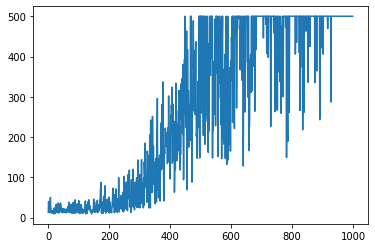

In [ ]:
plt.plot(rewards_history)

In [ ]:
np.max(rewards_history)

500.0